In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
dataset = pd.read_csv('thermal_conductivity_final.csv')
X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
base_models = [
    ("random_forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("xgboost", XGBRegressor(n_estimators=100, random_state=42))
]

In [9]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

In [10]:
meta_features_train = np.zeros((X_train.shape[0], len(base_models)))
meta_features_test = np.zeros((X_test.shape[0], len(base_models)))

In [11]:
for i, (name, model) in enumerate(base_models):
    test_fold_predictions = np.zeros((X_test.shape[0], n_folds))
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        
        model.fit(X_fold_train, y_fold_train)

        
        meta_features_train[val_idx, i] = model.predict(X_fold_val)
        test_fold_predictions[:, fold] = model.predict(X_test)

    
    meta_features_test[:, i] = test_fold_predictions.mean(axis=1)

In [12]:
meta_model = LinearRegression()
meta_model.fit(meta_features_train, y_train)

LinearRegression()

In [13]:
train_predictions = meta_model.predict(meta_features_train)
test_predictions = meta_model.predict(meta_features_test)


train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)


test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)

In [14]:
print("Training Metrics:")
print(f"MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}, MAPE: {train_mape:.2f}%")
print("\nTesting Metrics:")
print(f"MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}, MAPE: {test_mape:.2f}%")

Training Metrics:
MSE: 0.0000, RMSE: 0.0007, MAE: 0.0001, R²: 0.9989, MAPE: 0.01%

Testing Metrics:
MSE: 0.0000, RMSE: 0.0012, MAE: 0.0001, R²: 0.9967, MAPE: 0.01%


In [15]:
meta_features_full = np.zeros((X.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    meta_features_full[:, i] = model.predict(X)


In [16]:
predictions = meta_model.predict(meta_features_full)

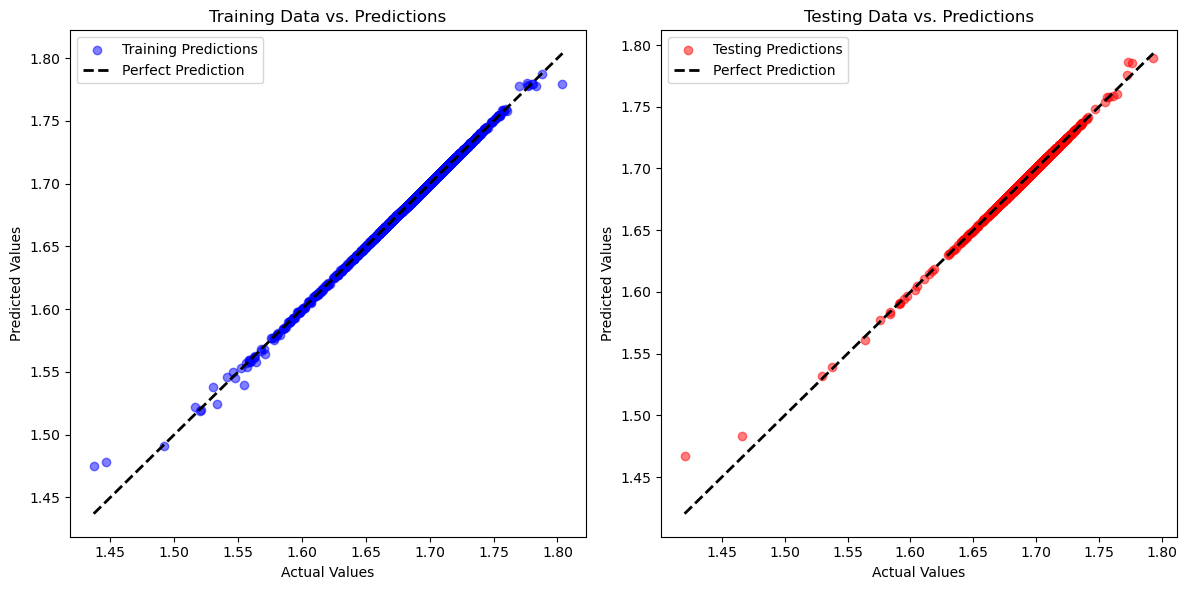

In [17]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions, alpha=0.5, color="blue", label="Training Predictions")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Training Data vs. Predictions")
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(y_test, test_predictions, alpha=0.5, color="red", label="Testing Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Testing Data vs. Predictions")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
new_df = pd.DataFrame({'Predictions': predictions})
joined_data = dataset.join(new_df)
joined_data.head()

,GR,DPHI,TNPH,TBIT10,TBIT20,TBIT30,TBIT60,TBIT90,DTCO_MPS_FINAL,DTSH_PNS_FINAL,RHOB,YME_STA,UCS,DTST,SLOANI,TIMANI,TXSG_ISO,TZSG,K(cond),Predictions
0,133.2880,0.035372,0.061501,1950.0,876.0785,85.85635,236.7023,1430.5400,56.94103,98.89021,2.591483,3.802793,16131.45,208.0918,-4.069155,0.818450,0.850168,1.103766,1.694190,1.694194
1,141.2310,0.034830,0.061533,1950.0,797.6779,77.46809,207.2923,720.5583,56.97847,100.58660,2.592007,3.885505,16482.31,208.0757,-4.029021,0.740217,0.848855,1.103768,1.695031,1.695037
2,137.1627,0.030458,0.060160,1950.0,488.2031,59.74663,119.4464,302.2662,57.15356,102.12170,2.595690,3.986692,16911.55,208.0272,-5.852238,0.642289,0.848307,1.103769,1.701835,1.701866
3,140.2624,0.032882,0.059916,1950.0,633.6127,61.63119,132.2877,319.1900,57.41502,103.30590,2.594137,4.044345,17156.11,207.9688,-4.997652,0.549908,0.845671,1.103771,1.698059,1.698076
4,151.1480,0.031895,0.059520,1950.0,803.0419,62.33526,161.0621,608.9658,57.77623,103.88680,2.598559,4.110643,17437.35,207.9688,-5.015064,0.419688,0.843553,1.103773,1.699596,1.699611


In [19]:
new_df = pd.DataFrame({'Predictions': predictions})
joined_data = dataset.join(new_df)
joined_data.head()

,GR,DPHI,TNPH,TBIT10,TBIT20,TBIT30,TBIT60,TBIT90,DTCO_MPS_FINAL,DTSH_PNS_FINAL,RHOB,YME_STA,UCS,DTST,SLOANI,TIMANI,TXSG_ISO,TZSG,K(cond),Predictions
0,133.2880,0.035372,0.061501,1950.0,876.0785,85.85635,236.7023,1430.5400,56.94103,98.89021,2.591483,3.802793,16131.45,208.0918,-4.069155,0.818450,0.850168,1.103766,1.694190,1.694194
1,141.2310,0.034830,0.061533,1950.0,797.6779,77.46809,207.2923,720.5583,56.97847,100.58660,2.592007,3.885505,16482.31,208.0757,-4.029021,0.740217,0.848855,1.103768,1.695031,1.695037
2,137.1627,0.030458,0.060160,1950.0,488.2031,59.74663,119.4464,302.2662,57.15356,102.12170,2.595690,3.986692,16911.55,208.0272,-5.852238,0.642289,0.848307,1.103769,1.701835,1.701866
3,140.2624,0.032882,0.059916,1950.0,633.6127,61.63119,132.2877,319.1900,57.41502,103.30590,2.594137,4.044345,17156.11,207.9688,-4.997652,0.549908,0.845671,1.103771,1.698059,1.698076
4,151.1480,0.031895,0.059520,1950.0,803.0419,62.33526,161.0621,608.9658,57.77623,103.88680,2.598559,4.110643,17437.35,207.9688,-5.015064,0.419688,0.843553,1.103773,1.699596,1.699611


In [20]:
dataset_thermal = pd.read_csv('thermal_conductivity.csv')

In [21]:
N = dataset_thermal.iloc[:, 0]
print(N)

0        6008.0
1        6008.5
2        6009.0
3        6009.5
4        6010.0
         ...   
9685    10890.0
9686    10890.5
9687    10891.0
9688    10891.5
9689    10892.0
Name: MD, Length: 9690, dtype: float64


In [22]:
new = pd.DataFrame({'Depth': N})
joined_data = joined_data.join(new)
joined_data.head()

,GR,DPHI,TNPH,TBIT10,TBIT20,TBIT30,TBIT60,TBIT90,DTCO_MPS_FINAL,DTSH_PNS_FINAL,...,YME_STA,UCS,DTST,SLOANI,TIMANI,TXSG_ISO,TZSG,K(cond),Predictions,Depth
0,133.2880,0.035372,0.061501,1950.0,876.0785,85.85635,236.7023,1430.5400,56.94103,98.89021,...,3.802793,16131.45,208.0918,-4.069155,0.818450,0.850168,1.103766,1.694190,1.694194,6008.0
1,141.2310,0.034830,0.061533,1950.0,797.6779,77.46809,207.2923,720.5583,56.97847,100.58660,...,3.885505,16482.31,208.0757,-4.029021,0.740217,0.848855,1.103768,1.695031,1.695037,6008.5
2,137.1627,0.030458,0.060160,1950.0,488.2031,59.74663,119.4464,302.2662,57.15356,102.12170,...,3.986692,16911.55,208.0272,-5.852238,0.642289,0.848307,1.103769,1.701835,1.701866,6009.0
3,140.2624,0.032882,0.059916,1950.0,633.6127,61.63119,132.2877,319.1900,57.41502,103.30590,...,4.044345,17156.11,207.9688,-4.997652,0.549908,0.845671,1.103771,1.698059,1.698076,6009.5
4,151.1480,0.031895,0.059520,1950.0,803.0419,62.33526,161.0621,608.9658,57.77623,103.88680,...,4.110643,17437.35,207.9688,-5.015064,0.419688,0.843553,1.103773,1.699596,1.699611,6010.0


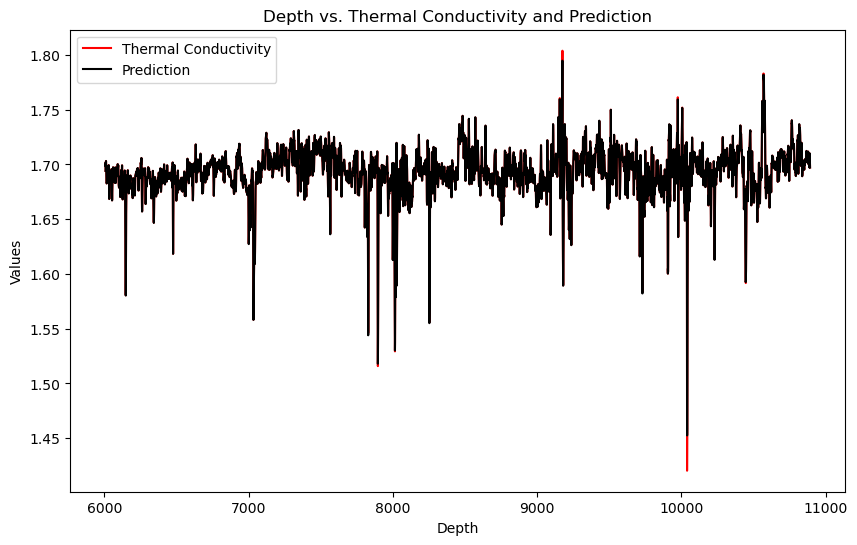

In [23]:
plt.figure(figsize=(10, 6))

# Plotting Heat Capacity vs. Depth
plt.plot(joined_data['Depth'], joined_data['K(cond)'], label='Thermal Conductivity', color='red')

# Plotting Prediction vs. Depth
plt.plot(joined_data['Depth'], joined_data['Predictions'], label='Prediction', color='black')

# Line of perfect prediction for Heat Capacity (y=x line assuming Prediction ideally matches Heat Capacity)


# Adding labels and legend
plt.xlabel('Depth')
plt.ylabel('Values')
plt.title('Depth vs. Thermal Conductivity and Prediction')
plt.legend()  # Automatically uses labels from each plot command

# Show the plot
plt.show()